In [1]:
import argparse
import pathlib
import random
from collections import deque
from typing import List, Dict, Tuple, Union
from data import Dataset, SuperclassDataset
from data_utils import *
from models import BetaBernoulli
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sampling import *
%matplotlib inline  

import matplotlib;matplotlib.rcParams['font.size'] = 12
import matplotlib;matplotlib.rcParams['font.family'] = 'serif'
LINEWIDTH = 13.97

In [2]:
DATASET_LIST = ['svhn']
metric = 'difference' # 'ece', 'confusion_matrix'
group_method = 'predicted_class'
rope_width=0.05

In [91]:
def rope(ax, alpha0, alpha1, beta0, beta1, rope_width=0.01):
    num_samples = 100000
    theta_0 = np.random.beta(alpha0, beta0, size=(num_samples,))
    theta_1 = np.random.beta(alpha1, beta1, size=(num_samples,))
    delta = theta_0 - theta_1
    vals = ((delta < -rope_width).mean(), (np.abs(delta) <= rope_width).mean(), (delta > rope_width).mean())
    ax.hist(delta, bins=100, color = 'b', label='Bayesian', alpha=0.5)
    ax.axvline(x=-rope_width, label='rope', color='gold', linewidth = 4)
    ax.axvline(x=rope_width, color='gold', linewidth = 5)
    
    frequentist = (alpha0) / (alpha0+beta0) - (alpha1) / (alpha1+beta1)
    budget = alpha0 + alpha1 + beta0 + beta1 - 4
    ax.axvline(x=frequentist, color='red', linewidth = 4, label='Frequentist', linestyle='--')
    #ax.set_xlim(-0.05, 0.05)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.yaxis.set_ticks([])
    ax.annotate('$P(\Delta<-\epsilon)=${:.2f}\n$P(-\epsilon\leq\Delta\leq\epsilon)=${:.2f}\n$P(\Delta>\epsilon)=${:.2f}\n\n$N_1+N_2=${:.0f}'.\
                format(vals[0], vals[1], vals[2], budget), xy=(0.1, 1.01), xycoords='axes fraction', \
                fontsize=11, ha='left', va='top')
    vals = ax.get_xticks()
    ax.set_xticklabels(['{:,.1%}'.format(x) for x in vals])
    return ax

In [85]:
from data_utils import eval_ece, DATAFILE_DICT
import numpy as np
from typing import List, Tuple, Dict, Deque, Iterable
from sklearn.metrics import confusion_matrix
from collections import deque, defaultdict
from sklearn.utils import shuffle 
class SuperclassDataset(Dataset):
    """
    different from the implementation in data.py
    """
    def __init__(self,
                 labels: np.ndarray,
                 scores: np.ndarray,
                 dataset_name: str,
                 superclass_lookup: Dict[int, int]) -> None:
        self.labels = labels
        self.scores = scores
        self.indices = np.arange(labels.shape[0])
        
        self.superclass_lookup = superclass_lookup
        self.reverse_lookup = defaultdict(list)
        for key, value in self.superclass_lookup.items():
            self.reverse_lookup[value].append(key)
        self.num_classes = len(self.reverse_lookup)
        
        self.superclass_labels = np.array([self.superclass_lookup[class_idx] for class_idx in self.predictions])
        
        self.num_groups = 20
        self.categories = self.predictions
        for k in range(20):
            self.accuracy_k = np.array([((self.labels == self.predictions)[self.superclass_labels  == superclass_idx]).mean()
                                        for superclass_idx in range(20)])
            self.weight_k = np.array([(self.superclass_labels == superclass_idx).sum() * 1.0 / self.__len__()
                                     for superclass_idx in range(20)])
        
        self._add_information('superclass_' + dataset_name)
        
    def _add_information(self, dataset_name):
        self.dataset_name = dataset_name
        self.accuracy = (self.labels == self.predictions).mean()
        self.ece = eval_ece(np.max(self.scores,axis=-1), (self.labels == self.predictions), NUM_BINS)
        
    @classmethod
    def load_from_text(cls, dataset_name: str, superclass_lookup: Dict[int, int]) -> 'Dataset':
        fname = DATAFILE_DICT[dataset_name]
        array = np.genfromtxt(fname)
        labels = array[:, 0].astype(np.int)
        scores = array[:, 1:].astype(np.float)
        return cls(labels, scores, dataset_name, superclass_lookup)   

No handles with labels found to put in legend.


group0, accuracy: people 0.58004158004158
group0, accuracy: trees 0.684931506849315
279.99999999999994 351.0 203.0 162.00000000000003
group0, accuracy: woman 0.5504587155963303
group1, accuracy: man 0.6666666666666666
61.0 53.0 50.0 27.000000000000004


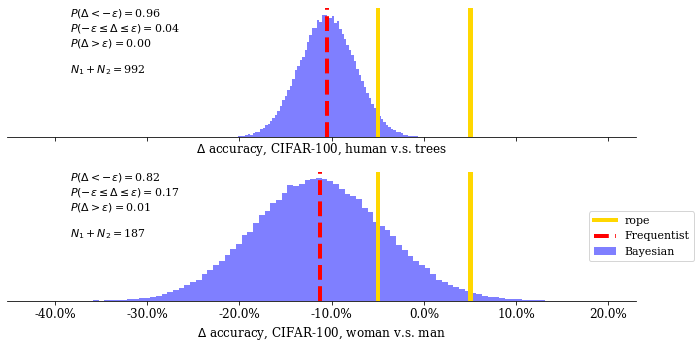

In [92]:
experiment_configs = [
    #('svhn', [6], [9], '6', '9'),
    #('superclass_cifar100', [14], [i for i in range(20) if i != 14], 'human', 'others'),
     ('superclass_cifar100', [14], [17], 'human', 'trees'),
    # ('cifar100', [35], [11], 'girl', 'boy'),
    ('cifar100', [98], [46], 'woman', 'man')
]
fig, axes = plt.subplots(nrows=len(experiment_configs), ncols=1, figsize=(LINEWIDTH*0.7,5), sharex=True)

for i, config in enumerate(experiment_configs):
    
    dataset_name, group0_list, group1_list, group0_name, group1_name = config   
    if len(dataset_name) > len('superclass') and dataset_name[:len('superclass')] == 'superclass':
        superclass = True
        dataset_name = 'cifar100'
        dataset = SuperclassDataset.load_from_text('cifar100', CIFAR100_SUPERCLASS_LOOKUP)
    else:
        superclass = False
        dataset = Dataset.load_from_text(dataset_name)
        dataset.group(group_method = group_method)
    
    dataset_len = dataset.__len__()
    dataset_accuracy_k = dataset.accuracy_k
    dataset_counts_k = dataset.weight_k * dataset_len
    del dataset
    
    
    alpha0, alpha1, beta0, beta1 = 1.0, 1.0, 1.0, 1.0
    for group0 in group0_list:
        if superclass:
            print('group0, accuracy:', CIFAR100_SUPERCLASSES[group0], dataset_accuracy_k[group0])
        else:
            print('group0, accuracy:', CIFAR100_CLASSES[group0], dataset_accuracy_k[group0])
        alpha0 += dataset_counts_k[group0] * (dataset_accuracy_k[group0])
        beta0  += dataset_counts_k[group0] * ((1-dataset_accuracy_k[group0]))
    for group1 in group1_list:
        if superclass:
            print('group0, accuracy:', CIFAR100_SUPERCLASSES[group1], dataset_accuracy_k[group1])
        else:     
            print('group1, accuracy:', CIFAR100_CLASSES[group1], dataset_accuracy_k[group1])
        alpha1 += dataset_counts_k[group1] * (dataset_accuracy_k[group1])
        beta1  += dataset_counts_k[group1] * ((1-dataset_accuracy_k[group1]))
    print(float(alpha0), float(alpha1), float(beta0), float(beta1))
    axes[i] = rope(axes[i], float(alpha0), float(alpha1), float(beta0), float(beta1), rope_width)
    axes[1].legend(loc='center right', fontsize=11, bbox_to_anchor=(1.1, 0.5))
    axes[i].set_xlabel(r"$\Delta$ accuracy, %s, %s v.s. %s" % \
                       (DATASET_NAMES[dataset_name], group0_name, group1_name), fontsize=12)
plt.subplots_adjust(hspace=2.0)
plt.tight_layout()

In [88]:
CIFAR100_CLASSES = [
    "apple", "aquarium_fish", "baby", "bear", "beaver", "bed", "bee", "beetle", "bicycle",
    "bottle", "bowl", "boy", "bridge", "bus", "butterfly", "camel", "can", "castle",
    "caterpillar", "cattle", "chair", "chimpanzee", "clock", "cloud", "cockroach", "couch",
    "crab", "crocodile", "cup", "dinosaur", "dolphin", "elephant", "flatfish", "forest", "fox",
    "girl", "hamster", "house", "kangaroo", "keyboard", "lamp", "lawn_mower", "leopard", "lion",
    "lizard", "lobster", "man", "maple_tree", "motorcycle", "mountain", "mouse", "mushroom",
    "oak_tree", "orange", "orchid", "otter", "palm_tree", "pear", "pickup_truck", "pine_tree",
    "plain", "plate", "poppy", "porcupine", "possum", "rabbit", "raccoon", "ray", "road",
    "rocket", "rose", "sea", "seal", "shark", "shrew", "skunk", "skyscraper", "snail", "snake",
    "spider", "squirrel", "streetcar", "sunflower", "sweet_pepper", "table", "tank", "telephone",
    "television", "tiger", "tractor", "train", "trout", "tulip", "turtle", "wardrobe", "whale",
    "willow_tree", "wolf", "woman", "worm"
]
CIFAR100_SUPERCLASSES = [
    "aquatic_mammals", "fish", "flowers", "food_containers", "fruit_and_vegetables",
    "household_electrical_devices", "household_furniture", "insects", "large_carnivores",
    "large_man-made_outdoor_things", "large_natural_outdoor_scenes",
    "large_omnivores_and_herbivores", "medium_mammals", "non-insect_invertebrates", "people",
    "reptiles", "small_mammals", "trees", "vehicles_1", "vehicles_2"
]
CIFAR100_REVERSE_SUPERCLASS_LOOKUP = {
    "aquatic_mammals": ["beaver", "dolphin", "otter", "seal", "whale"],
    "fish": ["aquarium_fish", "flatfish", "ray", "shark", "trout"],
    "flowers": ["orchid", "poppy", "rose", "sunflower", "tulip"],
    "food_containers": ["bottle", "bowl", "can", "cup", "plate"],
    "fruit_and_vegetables": ["apple", "mushroom", "orange", "pear", "sweet_pepper"],
    "household_electrical_devices": ["clock", "keyboard", "lamp", "telephone", "television"],
    "household_furniture": ["bed", "chair", "couch", "table", "wardrobe"],
    "insects": ["bee", "beetle", "butterfly", "caterpillar", "cockroach"],
    "large_carnivores": ["bear", "leopard", "lion", "tiger", "wolf"],
    "large_man-made_outdoor_things": ["bridge", "castle", "house", "road", "skyscraper"],
    "large_natural_outdoor_scenes": ["cloud", "forest", "mountain", "plain", "sea"],
    "large_omnivores_and_herbivores": ["camel", "cattle", "chimpanzee", "elephant", "kangaroo"],
    "medium_mammals": ["fox", "porcupine", "possum", "raccoon", "skunk"],
    "non-insect_invertebrates": ["crab", "lobster", "snail", "spider", "worm"],
    "people": ["baby", "boy", "girl", "man", "woman"],
    "reptiles": ["crocodile", "dinosaur", "lizard", "snake", "turtle"],
    "small_mammals": ["hamster", "mouse", "rabbit", "shrew", "squirrel"],
    "trees": ["maple_tree", "oak_tree", "palm_tree", "pine_tree", "willow_tree"],
    "vehicles_1": ["bicycle", "bus", "motorcycle", "pickup_truck", "train"],
    "vehicles_2": ["lawn_mower", "rocket", "streetcar", "tank", "tractor"]
}
print(CIFAR100_SUPERCLASSES.index('people'))

14


In [93]:
fig.savefig('../figures/rope.pdf', dpi=300, bbox_inches='tight', pad_inches=0)